In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity

In [18]:
# Load data - files are now in the same directory as the notebook
X_real = np.load("patient_data.npy")
X_synthetic = np.load("synthetic_patients.npy")

In [19]:
print(f"✓ Loaded real data: {X_real.shape}")
print(f"✓ Loaded synthetic data: {X_synthetic.shape}")

✓ Loaded real data: (297, 13)
✓ Loaded synthetic data: (500, 13)


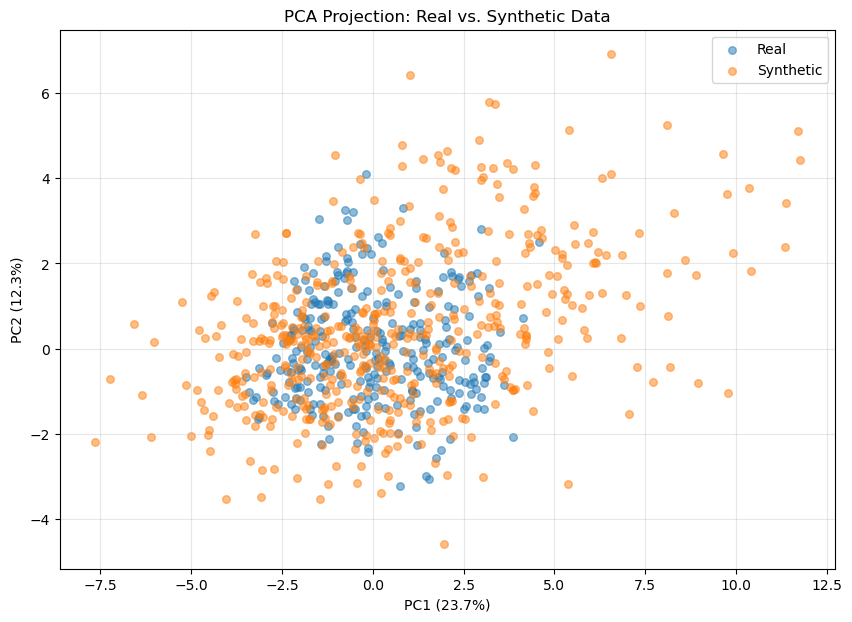

✓ Explained variance: 36.0%


In [20]:
# Standardize data
scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_real)
X_synthetic_scaled = scaler.transform(X_synthetic)

# Apply PCA
pca = PCA(n_components=2)
real_proj = pca.fit_transform(X_real_scaled)
synthetic_proj = pca.transform(X_synthetic_scaled)

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(real_proj[:, 0], real_proj[:, 1], alpha=0.5, label="Real", s=30)
plt.scatter(synthetic_proj[:, 0], synthetic_proj[:, 1], alpha=0.5, label="Synthetic", s=30)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.title("PCA Projection: Real vs. Synthetic Data")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("pca_projection.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Explained variance: {pca.explained_variance_ratio_.sum():.1%}")

Fitting K-Means...

=== K-Means Clustering Statistics ===
Real avg intra-cluster distance: 2.9083
Synthetic avg intra-cluster distance: 5.4394
Real cluster distribution: [71 53 34 65 74]
Synthetic cluster distribution: [165  53  58 162  62]


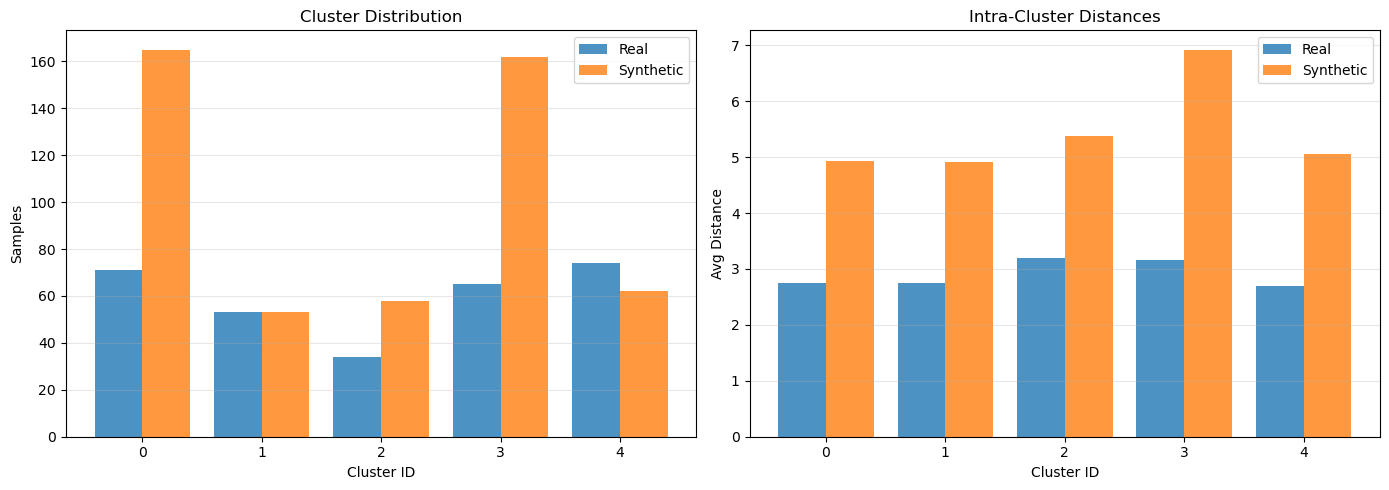

✓ Saved: kmeans_statistics.png


In [23]:
# Load data
X_real = np.load("patient_data.npy").astype(np.float64)
X_synthetic = np.load("synthetic_patients.npy").astype(np.float64)

# Standardize
scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_real)
X_synthetic_scaled = scaler.transform(X_synthetic)

# Simple K-Means implementation
def kmeans_simple(X, n_clusters=5, max_iter=100, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    
    # Initialize centers randomly
    indices = np.random.choice(n_samples, n_clusters, replace=False)
    centers = X[indices].copy()
    
    for _ in range(max_iter):
        # Assign clusters
        distances = np.sqrt(((X - centers[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        
        # Update centers
        new_centers = np.array([X[labels == k].mean(axis=0) for k in range(n_clusters)])
        
        if np.allclose(centers, new_centers):
            break
        centers = new_centers
    
    return labels, centers

# Fit on real data
print("Fitting K-Means...")
n_clusters = 5
real_labels, centers = kmeans_simple(X_real_scaled, n_clusters=n_clusters)
synthetic_labels = np.argmin(np.sqrt(((X_synthetic_scaled - centers[:, np.newaxis])**2).sum(axis=2)), axis=0)

# Calculate intra-cluster distances
def intra_cluster_dist(X, labels, centers, n_clusters):
    distances = []
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            dist = np.mean(np.linalg.norm(cluster_points - centers[i], axis=1))
            distances.append(dist)
    return distances

real_intra = intra_cluster_dist(X_real_scaled, real_labels, centers, n_clusters)
synthetic_intra = intra_cluster_dist(X_synthetic_scaled, synthetic_labels, centers, n_clusters)

# Print results
print("\n=== K-Means Clustering Statistics ===")
print(f"Real avg intra-cluster distance: {np.mean(real_intra):.4f}")
print(f"Synthetic avg intra-cluster distance: {np.mean(synthetic_intra):.4f}")
print(f"Real cluster distribution: {np.bincount(real_labels)}")
print(f"Synthetic cluster distribution: {np.bincount(synthetic_labels)}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(n_clusters)
real_counts = np.bincount(real_labels, minlength=n_clusters)
synthetic_counts = np.bincount(synthetic_labels, minlength=n_clusters)

axes[0].bar(x - 0.2, real_counts, 0.4, label='Real', alpha=0.8)
axes[0].bar(x + 0.2, synthetic_counts, 0.4, label='Synthetic', alpha=0.8)
axes[0].set_xlabel('Cluster ID')
axes[0].set_ylabel('Samples')
axes[0].set_title('Cluster Distribution')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Pad distances to match n_clusters for plotting
real_intra_padded = real_intra + [0] * (n_clusters - len(real_intra))
synthetic_intra_padded = synthetic_intra + [0] * (n_clusters - len(synthetic_intra))

axes[1].bar(x - 0.2, real_intra_padded, 0.4, label='Real', alpha=0.8)
axes[1].bar(x + 0.2, synthetic_intra_padded, 0.4, label='Synthetic', alpha=0.8)
axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Avg Distance')
axes[1].set_title('Intra-Cluster Distances')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("kmeans_statistics.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: kmeans_statistics.png")

In [14]:
# MEASURING MEMBERSHIP INFERENCE RISK

# Find nearest neighbors in synthetic data for each real sample
similarity_matrix = cosine_similarity(X_real_scaled, X_synthetic_scaled)
max_similarity = np.max(similarity_matrix, axis=1)
privacy_score = np.mean(max_similarity)

print("=== Privacy Metrics ===")
print(f"Avg. max similarity (lower is better): {privacy_score:.4f}")
print(f"Samples with high similarity (>0.95): {np.sum(max_similarity > 0.95)}")
print(f"Privacy risk percentage: {(np.sum(max_similarity > 0.95) / len(X_real)) * 100:.2f}%")

=== Privacy Metrics ===
Avg. max similarity (lower is better): 0.7505
Samples with high similarity (>0.95): 1
Privacy risk percentage: 0.34%
